In [61]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import PairGrid, heatmap, kdeplot
import pandas as pd
import numpy as np
from cmocean import cm as cmo
from utils import *
from IPython.display import HTML, display

In [64]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['font.size'] = 16
display(HTML("<style>.container { width:95% !important; }</style>"))

In [21]:
# Fitting with PC from band-wise normalized then standardized rrs_rc
df_pca = pd.read_pickle('./pickleJar/df_4_pca4_frombwnorm_stdizd.pkl')
df_chl = np.log10(pd.read_pickle('./pickleJar/df_4_ML4chl.pkl')[['chl']])

In [23]:
df_chl.rename(columns={'chl': 'log10_chl'}, inplace=True)

In [28]:
df_pca.info(), df_chl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495 entries, 0 to 494
Data columns (total 6 columns):
PC1    494 non-null float64
PC2    494 non-null float64
PC3    494 non-null float64
PC4    494 non-null float64
PC5    494 non-null float64
PC6    494 non-null float64
dtypes: float64(6)
memory usage: 27.1 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 495 entries, 0 to 494
Data columns (total 1 columns):
log10_chl    424 non-null float64
dtypes: float64(1)
memory usage: 7.7 KB


(None, None)

In [29]:
df = pd.concat((df_pca, df_chl), axis=1)

In [33]:
df.shape

(495, 7)

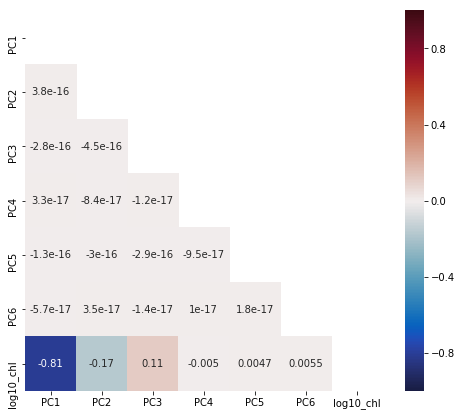

In [34]:
_, ax = pl.subplots(figsize=(8, 7))
heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap=cmo.balance,
       mask=np.triu(np.ones([df.shape[1]]*2)))

In [37]:
X = df.dropna().filter(regex='PC').values
y = df.dropna().log10_chl.values.reshape(-1, 1)

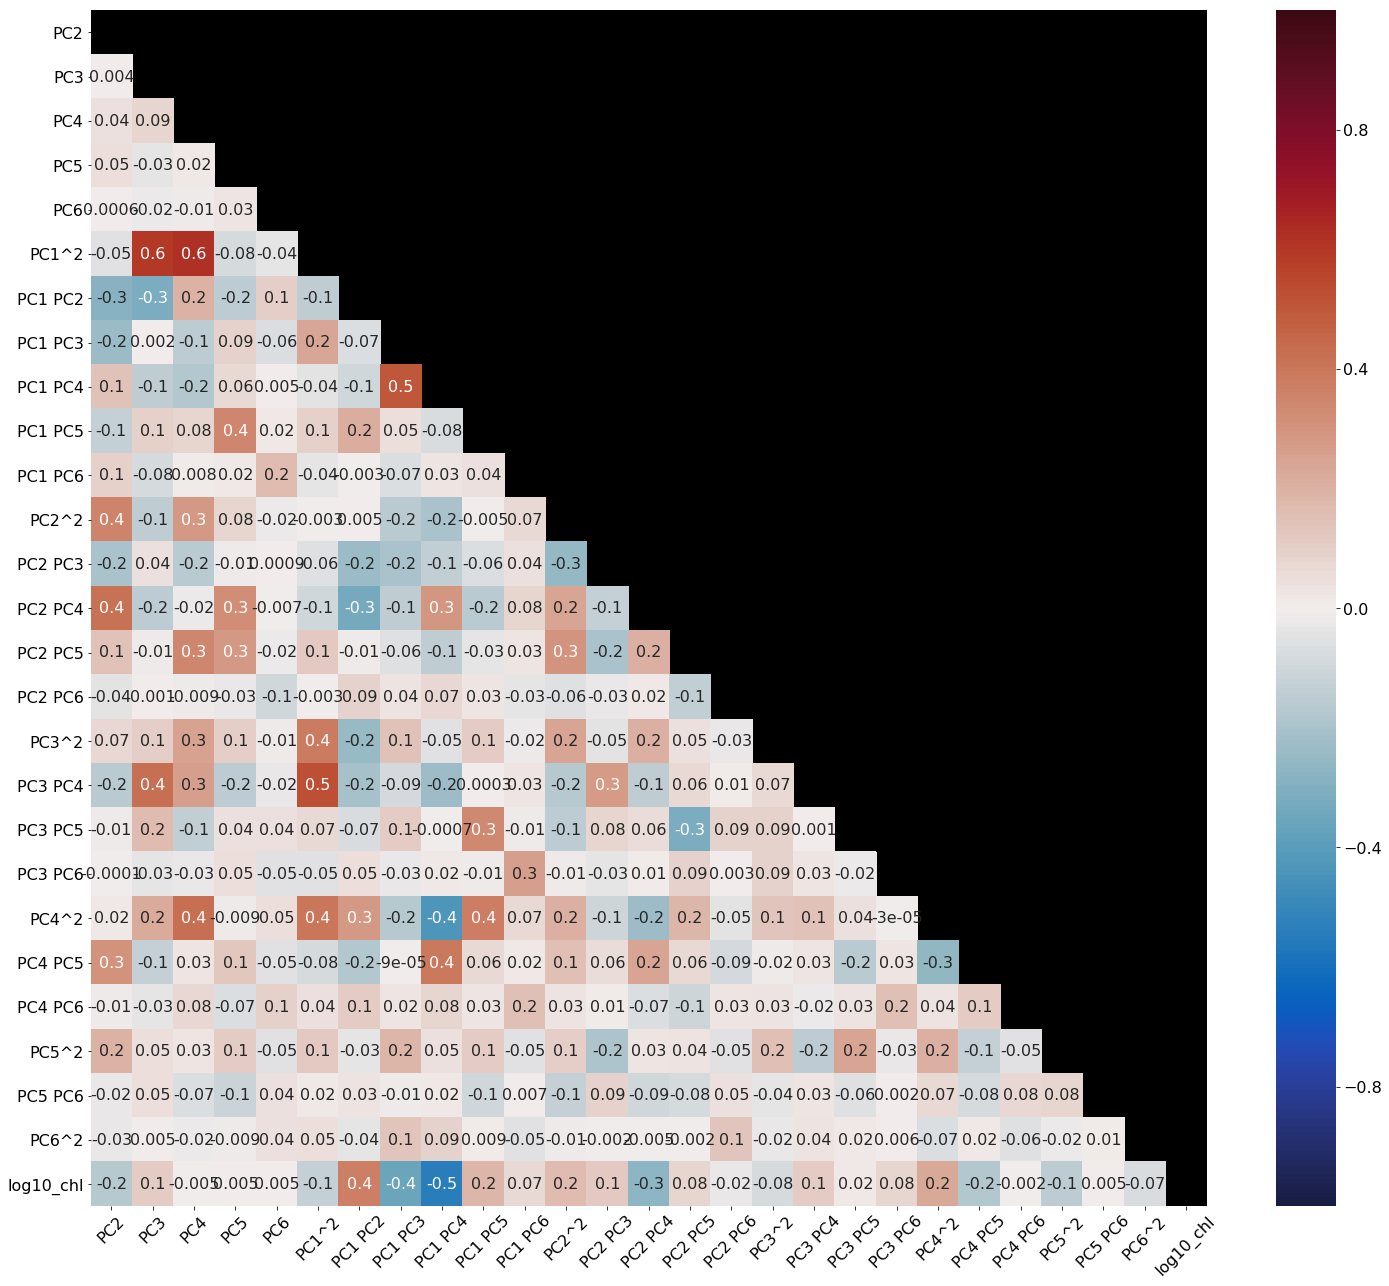

In [83]:
# Polynomial features:
polyFit = PolynomialFeatures()
Xpoly = polyFit.fit_transform(X)
poly_feat_names = polyFit.get_feature_names(['PC%d' %i for i in range(1, 7)])
dfpoly = pd.DataFrame(Xpoly, columns=poly_feat_names)
dfpoly['log10_chl'] = y

_, ax = pl.subplots(figsize=(25, 22))
ax.set_facecolor('k')
heatmap(dfpoly.iloc[:, 1:].corr().iloc[1:, 1:], vmin=-1, vmax=1, annot=True, cmap=cmo.balance,
       mask=np.triu(np.ones([dfpoly.shape[1]-2]*2)), fmt='.1g');
ax.tick_params(axis='x', rotation=45) 

In [79]:
# Polynomial features, interactions only
polyFit2 = PolynomialFeatures(interaction_only=True)

In [73]:
Xpoly2 = polyFit2.fit_transform(X)

In [74]:
poly_feat_names2 = polyFit2.get_feature_names(['PC%d' %i for i in range(1, 7)])

In [80]:
dfpoly2 = pd.DataFrame(Xpoly2, columns=poly_feat_names2)

In [77]:
dfpoly2['log10_chl'] = y

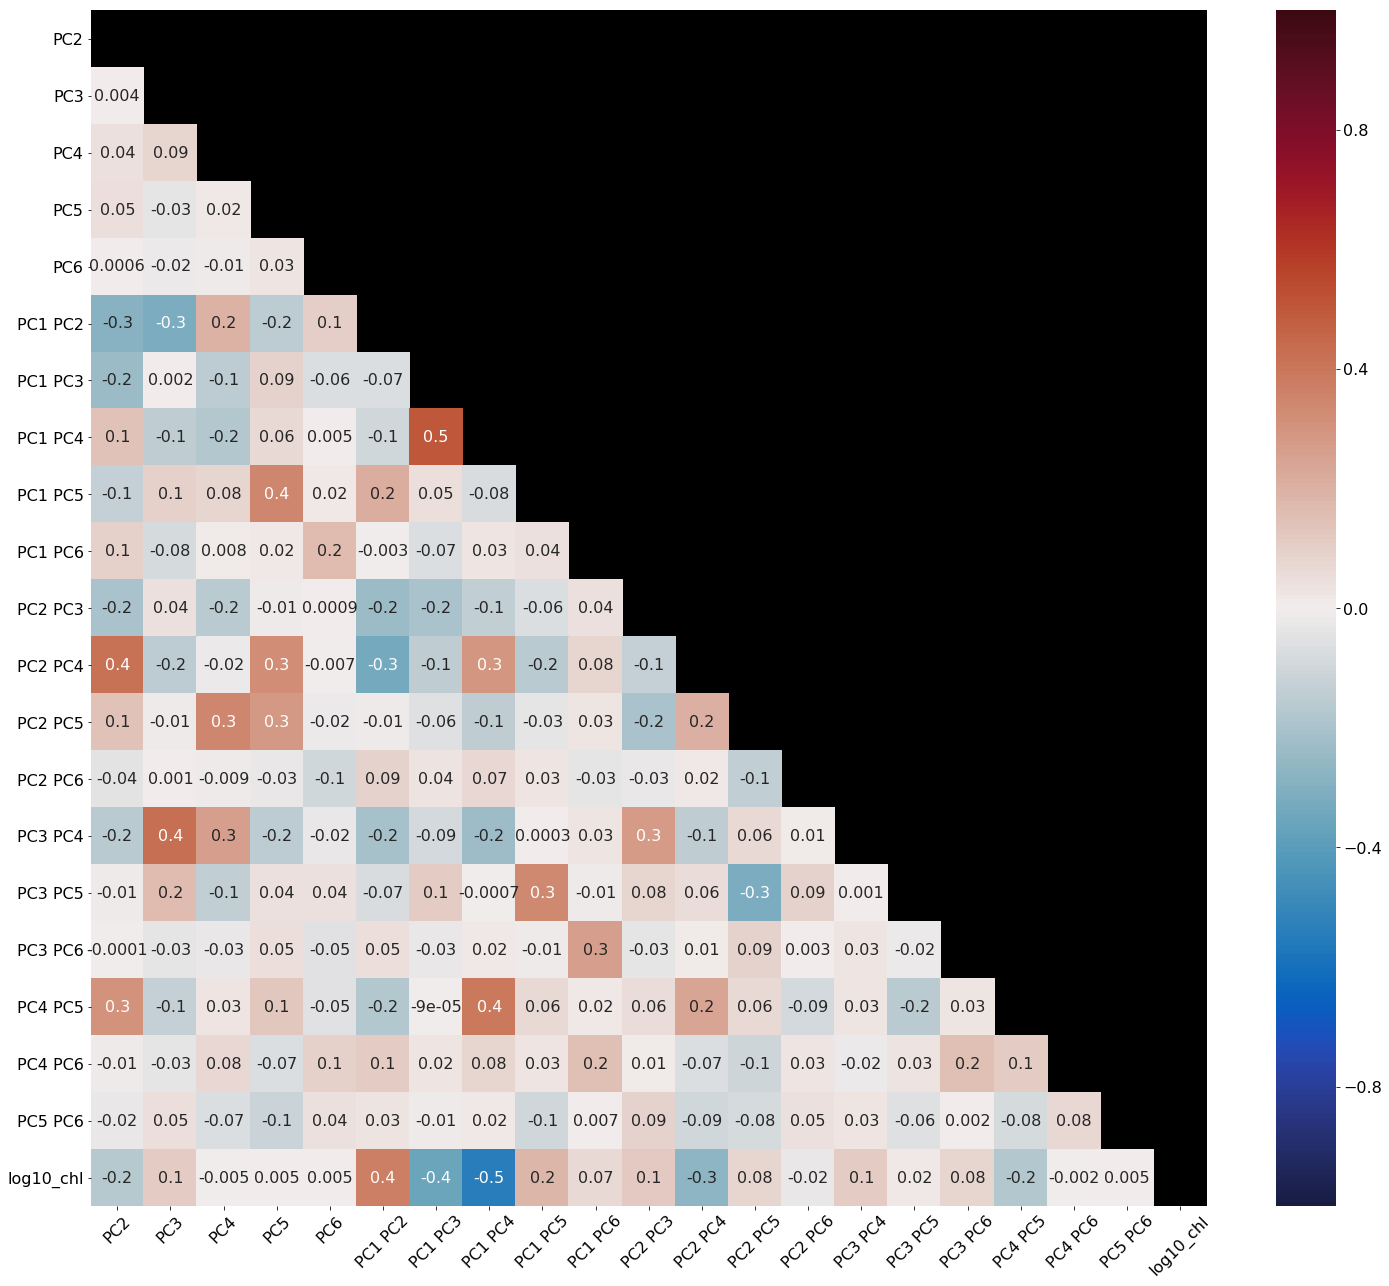

In [78]:
_, ax = pl.subplots(figsize=(25, 22))
ax.set_facecolor('k')
heatmap(dfpoly2.iloc[:, 1:].corr().iloc[1:, 1:], vmin=-1, vmax=1, annot=True, cmap=cmo.balance,
       mask=np.triu(np.ones([dfpoly2.shape[1]-2]*2)), fmt='.1g');
ax.tick_params(axis='x', rotation=45) 

In [86]:
clf = LassoCV()
sfm = SelectFromModel(clf)
sfm.fit(Xpoly2, y.ravel())
n_features = sfm.transform(Xpoly2).shape[1]

In [87]:
n_features

10

In [89]:
sfm.threshold_

1e-05